## Build custom circuits

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
num_uncertainty_qubits = 3

model_register = QuantumRegister(num_uncertainty_qubits, 'model')
objective_register = QuantumRegister(1, 'objective')
objective_measurement_register = ClassicalRegister(1, 'objective_measurement')


test_circuit = QuantumCircuit(model_register, objective_register, objective_measurement_register)

num = 6
c_approx = 0.1

binary_num = bin(num)[2:].zfill(num_uncertainty_qubits)

step = (np.pi/4) / (2**num_uncertainty_qubits) * c_approx

for i in range(num_uncertainty_qubits):
    if binary_num[::-1][i] == '1':
        test_circuit.x(model_register[i])

test_circuit.ry(np.pi/2, objective_register[0])

for i in range(num_uncertainty_qubits):
    test_circuit.cry(step*2**(i), model_register[i], objective_register[0])
        
test_circuit.measure(objective_register, objective_measurement_register)
test_circuit.draw()



model_0: ─────────────────■──────────────────────────────────
                            ┌───┐         │                                  
                model_1: ───┤ X ├─────────┼────────────■─────────────────────
                            ├───┤         │            │                     
                model_2: ───┤ X ├─────────┼────────────┼───────────■─────────
                         ┌──┴───┴──┐┌─────┴─────┐┌─────┴─────┐┌────┴─────┐┌─┐
              objective: ┤ Ry(π/2) ├┤ Ry(π/320) ├┤ Ry(π/160) ├┤ Ry(π/80) ├┤M├
                         └─────────┘└───────────┘└───────────┘└──────────┘└╥┘
objective_measurement: 1/══════════════════════════════════════════════════╩═
                                                                           0

In [2]:
from qiskit import Aer, execute

backend = Aer.get_backend('qasm_simulator')
job = execute(test_circuit, backend, shots=10000)
result = job.result()
counts = result.get_counts()
print(counts)

print((np.arcsin(np.sqrt(counts['1']/10000))-np.pi/4)/step*2)

{'0': 4720, '1': 5280}
5.707098725376637


In [3]:
all_results = []
num_samples = 10000
for _ in range(100):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(test_circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    all_results.append((np.arcsin(np.sqrt(counts['1']/10000))-np.pi/4)/step*2)

curr_mean = np.mean(all_results)
curr_std = np.std(all_results)
print("mean: {}, std: {}".format(curr_mean, curr_std))
print("confidence interval: [{}, {}]".format(curr_mean - 1.96*curr_std, curr_mean + 1.96*curr_std))
    

mean: 5.941880507140362, std: 1.065002606446419
confidence interval: [3.8544753985053806, 8.029285615775343]


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [7]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [8]:
print(uncertainty_model.values)
print(uncertainty_model.probabilities)

[1.20860724 1.43785917 1.66711109 1.89636302 2.12561495 2.35486687
 2.5841188  2.81337073]
[0.00045374 0.02293123 0.16681763 0.33977531 0.28936531 0.13310021
 0.0392238  0.00833277]


{'101': 132, '001': 16, '100': 307, '110': 42, '010': 166, '111': 5, '011': 332}


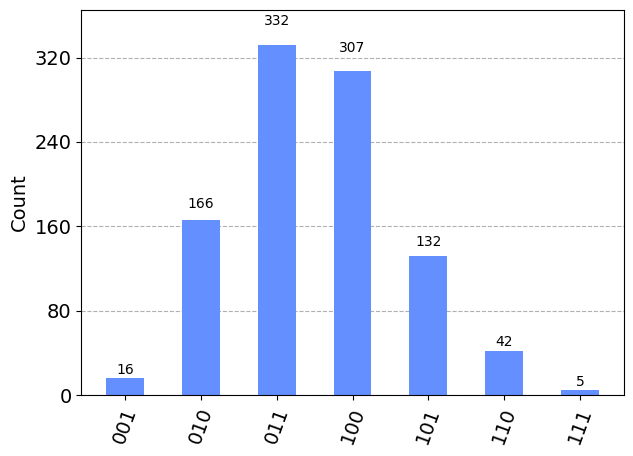

In [9]:
from qiskit import QuantumCircuit, execute, Aer
my_circ = QuantumCircuit(3)
my_circ.append(uncertainty_model, range(3))
my_circ.measure_all()   
job = execute(my_circ, Aer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [7]:
def basic_function_loader(num_uncertainty_qubits,c_approx=0.1):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')

    circuit_one = QuantumCircuit(model_register, objective_register)

    step = (np.pi/4) / (2**num_uncertainty_qubits-1) * c_approx
    offset = 2.5
    circuit.ry(-offset * step * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i)*2, model_register[i], objective_register[0])
        
    def post_processor(counts, num_samples):
        prob_of_one = counts/num_samples
        return (prob_of_one-0.5)/(step) + offset
    
    def post_processor_2(counts, num_samples):
        prob_of_one = counts/num_samples
        return (np.arcsin(np.sqrt(prob_of_one))-np.pi/4)/(step)
    return circuit.to_gate(label="F_custom"), post_processor, post_processor_2

model_register = QuantumRegister(num_uncertainty_qubits, 'model')
objective_register = QuantumRegister(1, 'objective')
objective_measurement_register = ClassicalRegister(1, 'objective_measurement')


test_circuit = QuantumCircuit(model_register, objective_register, objective_measurement_register)

c_approx = 0.5
f_custom, post_processor, post_processor_2 = basic_function_loader(num_uncertainty_qubits, c_approx=c_approx)

test_circuit.append(uncertainty_model, model_register)
test_circuit.ry(np.pi/2, objective_register[0])
test_circuit.append(f_custom, model_register[:] + objective_register[:])

test_circuit.measure(objective_register, objective_measurement_register)

test_circuit.draw()
        

┌───────┐ ┌───────────┐   
                model_0: ─┤0      ├─┤0          ├───
                          │       │ │           │   
                model_1: ─┤1 P(X) ├─┤1          ├───
                          │       │ │  F_custom │   
                model_2: ─┤2      ├─┤2          ├───
                         ┌┴───────┴┐│           │┌─┐
              objective: ┤ Ry(π/2) ├┤3          ├┤M├
                         └─────────┘└───────────┘└╥┘
objective_measurement: 1/═════════════════════════╩═
                                                  0

In [8]:
from qiskit import Aer, execute
num_samples = 100000
backend = Aer.get_backend('qasm_simulator')
all_results = []
all_second_results = []
for i in range(100):
    job = execute(test_circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    # print(counts)
    curr_results = post_processor(counts['1'], num_samples)/(2**num_uncertainty_qubits-1)*(high-low) + low
    all_results.append(curr_results)
    all_second_results.append(post_processor_2(counts['1'], num_samples)/(2**num_uncertainty_qubits-1)*(high-low) + low)

exact_expectation = uncertainty_model.probabilities.dot(uncertainty_model.values)
print("Exact value: {}".format(exact_expectation))
print("first processor: mean: {}, std: {}".format(np.mean(all_results), np.std(all_results)))
print("second processor: mean: {}, std: {}".format(np.mean(all_second_results), np.std(all_second_results)))

Exact value: 2.0092757589775023
first processor: mean: 2.007525396282952, std: 0.00636511402839486
second processor: mean: 1.4348587624438864, std: 0.0064040820270949705


# Check subtractor

In [10]:
from qfinance.helper import Subtractor

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

subtractor = Subtractor(num_uncertainty_qubits).circuit
model_register = QuantumRegister(num_uncertainty_qubits, 'model')
ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
carry_register = QuantumRegister(1, 'carry')
classical_measurement = ClassicalRegister(1, 'c')

subtractor = Subtractor(num_uncertainty_qubits).circuit
num_samples = 1000

for first_num in range(2**num_uncertainty_qubits):
    for second_num in range(2**num_uncertainty_qubits):
        circuit = QuantumCircuit(model_register, ancilla_register, carry_register, classical_measurement)
        loadNumber(circuit, model_register, first_num)
        loadNumber(circuit, ancilla_register, second_num)
        circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
        circuit.measure(carry_register, classical_measurement)
        backend = Aer.get_backend('qasm_simulator')
        job = execute(circuit, backend, shots=num_samples)
        result = job.result()
        counts = result.get_counts()
        carry = list(counts.keys())[0]
        print("first: {}, second: {}, carry: {}".format(first_num, second_num, carry))



first: 0, second: 0, carry: 0
first: 0, second: 1, carry: 1
first: 0, second: 2, carry: 1
first: 0, second: 3, carry: 1
first: 0, second: 4, carry: 1
first: 0, second: 5, carry: 1
first: 0, second: 6, carry: 1
first: 0, second: 7, carry: 1
first: 1, second: 0, carry: 0
first: 1, second: 1, carry: 0
first: 1, second: 2, carry: 1
first: 1, second: 3, carry: 1
first: 1, second: 4, carry: 1
first: 1, second: 5, carry: 1
first: 1, second: 6, carry: 1
first: 1, second: 7, carry: 1
first: 2, second: 0, carry: 0
first: 2, second: 1, carry: 0
first: 2, second: 2, carry: 0
first: 2, second: 3, carry: 1
first: 2, second: 4, carry: 1
first: 2, second: 5, carry: 1
first: 2, second: 6, carry: 1
first: 2, second: 7, carry: 1
first: 3, second: 0, carry: 0
first: 3, second: 1, carry: 0
first: 3, second: 2, carry: 0
first: 3, second: 3, carry: 0
first: 3, second: 4, carry: 1
first: 3, second: 5, carry: 1
first: 3, second: 6, carry: 1
first: 3, second: 7, carry: 1
first: 4, second: 0, carry: 0
first: 4, 

In [10]:
uncertainty_model.values

array([1.20860724, 1.43785917, 1.66711109, 1.89636302, 2.12561495,
       2.35486687, 2.5841188 , 2.81337073])

In [76]:
from qfinance.helper import Subtractor
# set the approximation scaling for the payoff function
c_approx = 0.1


low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
            
def basic_function_loader(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')

    mapped_strike_price_int = map_strike_price_int(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    circuit = QuantumCircuit(model_register, objective_register)
    
    step = (np.pi/4) / (2**num_uncertainty_qubits) * c_approx
    
    ## offset for more accurate approximation
    offset = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_int-1))/2
    # offset = 0
    print("offset: {}".format(offset))
    offset_angle = step*offset
    # circuit.ry(-step*offset, objective_register[0])
    
    # account for x - strike_price
    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i) * 2, model_register[i], objective_register[0])
        
    fmax = high - strike_price
    fmin = uncertainty_model.values[mapped_strike_price_int] - strike_price
    print("fmax: {}, fmin: {}".format(fmax, fmin))
    print("og range: {}".format(2**num_uncertainty_qubits - 1 - mapped_strike_price_float))
    print("percent: {}".format((2**num_uncertainty_qubits - 1 - mapped_strike_price_float)*step*2/(np.pi/4)))
    print("maximum angle: {}".format(step*(2**num_uncertainty_qubits - 1 - mapped_strike_price_float)))
    print("offset angle: {}".format(offset_angle))
    
    def post_processor(counts, num_samples):
        prob_of_one = counts/num_samples
        coeff = (prob_of_one-0.5)/(step) + offset
        fmax = high - strike_price
        # fmin = uncertainty_model.values[mapped_strike_price_int] - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor, offset_angle, step

strike_price = 2.1
# strike_price_2 = 1.7

# construct rotater for first strike
c_approx = 0.1
model_register = QuantumRegister(num_uncertainty_qubits, 'model')
objective_register = QuantumRegister(1, 'objective')
ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
carry_register = QuantumRegister(1, 'carry')
classical_measurement = ClassicalRegister(1, 'c')

subtractor = Subtractor(num_uncertainty_qubits).circuit

objective_fn, post_processor, offset_angle, step = basic_function_loader(num_uncertainty_qubits, strike_price, c_approx)
controlled_objective = objective_fn.control(ctrl_state='0')

circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register, classical_measurement)
# circuit.append(uncertainty_model, model_register)

# map sin(x) to sin(x+pi/4)
circuit.ry(np.pi/2, objective_register[0])

# offset 
circuit.ry(-offset_angle*2, objective_register[0])

first_num = 2

loadNumber(circuit, model_register, first_num)
loadNumber(circuit, ancilla_register, map_strike_price_int(strike_price, high, low, num_uncertainty_qubits))
circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])
circuit.measure(objective_register, classical_measurement)
# circuit.measure(carry_register, classical_measurement)

circuit.decompose(reps=0).draw()




offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207


┌─────────────┐┌───────────┐   
  model_0: ────────────────────────┤0            ├┤0          ├───
              ┌───┐                │             ││           │   
  model_1: ───┤ X ├────────────────┤1            ├┤1          ├───
              └───┘                │             ││  F_custom │   
  model_2: ────────────────────────┤2            ├┤2          ├───
           ┌─────────┐┌───────────┐│             ││           │┌─┐
objective: ┤ Ry(π/2) ├┤ Ry(-π/80) ├┤             ├┤3          ├┤M├
           └─────────┘└───────────┘│  subtractor │└─────┬─────┘└╥┘
ancilla_0: ────────────────────────┤3            ├──────┼───────╫─
                                   │             │      │       ║ 
ancilla_1: ────────────────────────┤4            ├──────┼───────╫─
              ┌───┐                │             │      │       ║ 
ancilla_2: ───┤ X ├────────────────┤5            ├──────┼───────╫─
              └───┘                │             │      │       ║ 
    carry: ────────────────────────┤6            ├──────o───────╫─
                                   └─────────────┘              ║ 
      c: 1/═════════════════════════════════════════════════════╩═
                                                                0

In [77]:
from qiskit import Aer, execute
num_samples = 1000000
backend = Aer.get_backend('aer_simulator')
all_results = []
all_second_results = []
unprocessed_results = []
for i in range(10):
    job = execute(circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    print(((counts['1']/num_samples)-0.5)/step)
    unprocessed_results.append(((counts['1']/num_samples)-0.5)/step)
    curr_results = post_processor(counts['1'], num_samples)
    all_results.append(curr_results)

print("Exact value: {}".format(max(0, max(uncertainty_model.values[first_num] - strike_price, 0))))
print("estimated: mean: {}, std: {}".format(np.mean(all_results), np.std(all_results)))
print("unprocessed: mean: {}, std: {}".format(np.mean(unprocessed_results), np.std(unprocessed_results)))

-1.991244788802214
-1.9579368423119456
-1.905784950559592
-2.063462935779594
-1.9930782537466345
-1.9036459081244377
-1.983096055715912
-1.9934856904009501
-1.9450007285374318
-2.021191382894387
Exact value: 0
estimated: mean: 0.005549557865773892, std: 0.010758798236894865
unprocessed: mean: -1.9757927536873097, std: 0.046930023120451116


In [78]:
value = np.array(list(range(8)))
value = np.array([value[i] - map_strike_price_float(strike_price, high, low, num_uncertainty_qubits) if value[i] >= map_strike_price_int(strike_price, high, low, num_uncertainty_qubits) else 0 for i in range(8)])
value -= 2
print(value)
value.dot(uncertainty_model.probabilities)


[-2.         -2.         -2.         -2.         -1.88826726 -0.88826726
  0.11173274  1.11173274]


-1.7109370337143113

In [79]:
num_samples = 1000000
backend = Aer.get_backend('aer_simulator')
all_results = []
all_results_std = []
for first_num in range(8):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
    carry_register = QuantumRegister(1, 'carry')
    classical_measurement = ClassicalRegister(1, 'c')

    subtractor = Subtractor(num_uncertainty_qubits).circuit

    objective_fn, post_processor, offset_angle, step = basic_function_loader(num_uncertainty_qubits, strike_price, c_approx)
    controlled_objective = objective_fn.control(ctrl_state='0')

    circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register, classical_measurement)
    # circuit.append(uncertainty_model, model_register)

    # map sin(x) to sin(x+pi/4)
    circuit.ry(np.pi/2, objective_register[0])

    # offset 
    circuit.ry(-offset_angle*2, objective_register[0])

    loadNumber(circuit, model_register, first_num)
    loadNumber(circuit, ancilla_register, map_strike_price_int(strike_price, high, low, num_uncertainty_qubits))
    circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
    circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])
    circuit.measure(objective_register, classical_measurement)
    
    all_curr_results = []
    for i in range(10):
        job = execute(circuit, backend, shots=num_samples)
        result = job.result()
        counts = result.get_counts()
        curr_results = post_processor(counts['1'], num_samples)
        all_curr_results.append(curr_results)
    curr_mean = np.mean(all_curr_results)
    curr_std = np.std(all_curr_results)
    all_results.append(curr_mean)
    all_results_std.append(curr_std)

offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207
offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207
offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207
offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207
offset: 2.0
fmax: 0.713370728095958, fmin: 0.025614946944015227
og range: 3.111732744293819
percent: 0.07779331860734548
maximum angle: 0.030549364779400838
offset angle: 0.019634954084936207
offset: 2.0
fmax: 0.713370728095958, fmi

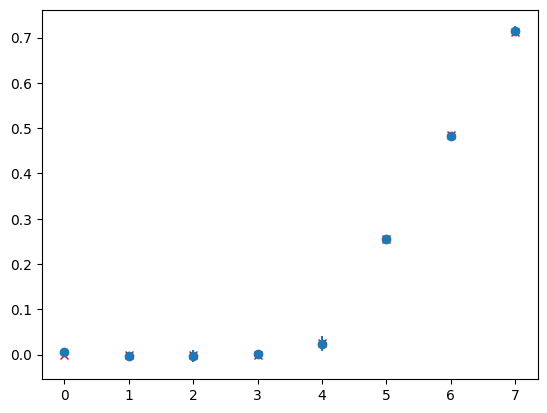

In [80]:
import matplotlib.pyplot as plt
plt.errorbar(list(range(8)), all_results, yerr=all_results_std, fmt='o')
value = np.array(list(range(8)))
value = np.array([uncertainty_model.values[i] - strike_price if uncertainty_model.values[i]> strike_price else 0 for i in range(8)])
plt.plot(list(range(8)), value, 'rx')

In [303]:
positive_values = uncertainty_model.values[uncertainty_model.values > strike_price]
corresponding_probs = uncertainty_model.probabilities[uncertainty_model.values > strike_price]
exact_expectation = corresponding_probs.dot(positive_values - strike_price)
print(positive_values - strike_price)
print(corresponding_probs)
print("Exact value: {}".format(exact_expectation))

[0.02561495 0.25486687 0.4841188  0.71337073]
[0.28936531 0.13310021 0.0392238  0.00833277]
Exact value: 0.06626824205997056


In [304]:
total = 0
for i in range(num_uncertainty_qubits):
    total += 2**(i)
print(total)

7


In [69]:
from qfinance.helper import Subtractor
# set the approximation scaling for the payoff function
c_approx = 0.1


low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    # print("strike_price: {}".format(strike_price))
    # print("ceil: {}".format(int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))))
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = "0" * (register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
            
def basic_function_loader(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')

    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price(strike_price, high, low, num_uncertainty_qubits)
    offset = (2**num_uncertainty_qubits - mapped_strike_price_int)/2
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    # circuit.ry(-step*offset*2, objective_register[0])
    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(counts, num_samples):
        prob_of_one = counts/num_samples
        coeff = (prob_of_one-0.5)/(step)
        fmax = high - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor

strike_price = 2.1
# strike_price_2 = 1.7

# construct rotater for first strike
c_approx = 0.1
model_register = QuantumRegister(num_uncertainty_qubits, 'model')
objective_register = QuantumRegister(1, 'objective')
ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
carry_register = QuantumRegister(1, 'carry')
classical_measurement = ClassicalRegister(1, 'c')

subtractor = Subtractor(num_uncertainty_qubits).circuit

objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, strike_price, c_approx)
controlled_objective = objective_fn.control(ctrl_state='0')

circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register, classical_measurement)
circuit.append(uncertainty_model, model_register)

circuit.ry(np.pi/2, objective_register[0])


# loadNumber(circuit, model_register, first_num)
loadNumber(circuit, ancilla_register, map_strike_price(strike_price, high, low, num_uncertainty_qubits))
circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])
circuit.measure(objective_register, classical_measurement)

circuit.decompose(reps=0).draw()

┌───────┐ ┌─────────────┐┌───────────┐   
  model_0: ─┤0      ├─┤0            ├┤0          ├───
            │       │ │             ││           │   
  model_1: ─┤1 P(X) ├─┤1            ├┤1          ├───
            │       │ │             ││  F_custom │   
  model_2: ─┤2      ├─┤2            ├┤2          ├───
           ┌┴───────┴┐│             ││           │┌─┐
objective: ┤ Ry(π/2) ├┤             ├┤3          ├┤M├
           └─────────┘│  subtractor │└─────┬─────┘└╥┘
ancilla_0: ───────────┤3            ├──────┼───────╫─
                      │             │      │       ║ 
ancilla_1: ───────────┤4            ├──────┼───────╫─
              ┌───┐   │             │      │       ║ 
ancilla_2: ───┤ X ├───┤5            ├──────┼───────╫─
              └───┘   │             │      │       ║ 
    carry: ───────────┤6            ├──────o───────╫─
                      └─────────────┘              ║ 
      c: 1/════════════════════════════════════════╩═
                                                   0

In [70]:
from qiskit import Aer, execute
num_samples = 1000000
backend = Aer.get_backend('qasm_simulator')
all_results = []
for i in range(20):
    job = execute(circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    # print(counts)
    curr_results = post_processor(counts['1'], num_samples)
    all_results.append(curr_results)


exact_expectation = 0
for i in range(len(uncertainty_model.probabilities)):
    exact_expectation += uncertainty_model.probabilities[i] * max(uncertainty_model.values[i] - strike_price, 0)

curr_mean = np.mean(all_results)
curr_std = np.std(all_results)

print("Exact value: {}".format(exact_expectation))
print("mean:{}, std: {}".format(np.mean(all_results), np.std(all_results)))
print("interval: [{}, {}]".format(curr_mean-1.96*curr_std, curr_mean+1.96*curr_std))

Exact value: 0.06626824205997056
mean:0.07450296402427813, std: 0.016012400370487834
interval: [0.04311865929812197, 0.10588726875043428]


In [103]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [71]:
all_strike_prices = np.linspace(low*1.01, high*0.99, 20)
c_approx = 0.01
num_samples = 1000000

all_mean = []
all_std = []
for strike_price in all_strike_prices:
    # construct rotater for first strike
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
    carry_register = QuantumRegister(1, 'carry')
    classical_measurement = ClassicalRegister(1, 'c')

    subtractor = Subtractor(num_uncertainty_qubits).circuit

    objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, strike_price, c_approx)
    controlled_objective = objective_fn.control(ctrl_state='0')

    circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register, classical_measurement)
    circuit.append(uncertainty_model, model_register)

    circuit.ry(np.pi/2, objective_register[0])


    # loadNumber(circuit, model_register, first_num)
    loadNumber(circuit, ancilla_register, map_strike_price(strike_price, high, low, num_uncertainty_qubits))
    circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
    circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])
    circuit.measure(objective_register, classical_measurement)
    curr_all_results = []
    for i in range(30):
        job = execute(circuit, backend, shots=num_samples)
        result = job.result()
        counts = result.get_counts()
        # print(counts)
        curr_results = post_processor(counts['1'], num_samples)
        curr_all_results.append(curr_results)
    
    curr_mean = np.mean(curr_all_results)
    curr_std = np.std(curr_all_results)
    all_mean.append(curr_mean)
    all_std.append(curr_std)

In [72]:
exact_expectations = []
for strike_price in all_strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(uncertainty_model.values[i] - strike_price, 0)
    exact_expectations.append(exact_expectation)

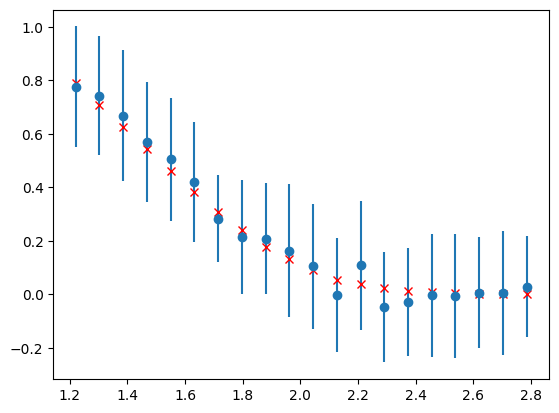

In [73]:
import matplotlib.pyplot as plt
plt.errorbar(all_strike_prices, all_mean, yerr=all_std, fmt='o')
plt.plot(all_strike_prices, exact_expectations, 'rx')

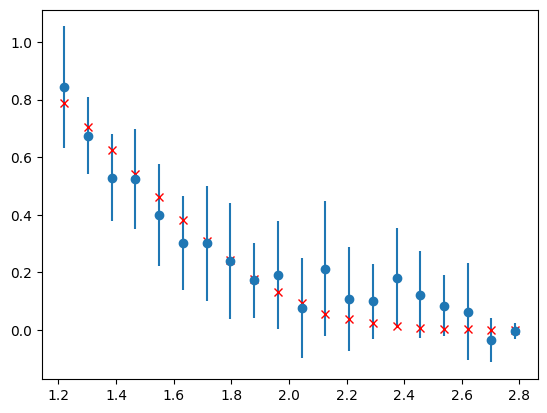

In [274]:
import matplotlib.pyplot as plt
plt.errorbar(all_strike_prices, all_mean, yerr=all_std, fmt='o')
plt.plot(all_strike_prices, exact_expectations, 'rx')

In [104]:
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler

strike_price = 1.8
# strike_price_2 = 1.7

# construct rotater for first strike

model_register = QuantumRegister(num_uncertainty_qubits, 'model')
objective_register = QuantumRegister(1, 'objective')
ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
carry_register = QuantumRegister(1, 'carry')

subtractor = Subtractor(num_uncertainty_qubits).circuit

def ae_function_loader(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')

    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price(strike_price, high, low, num_uncertainty_qubits)
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    offset = (2**num_uncertainty_qubits - 1 - mapped_strike_price_int)/2
    offset_angle = offset * step * 2
    # circuit.ry(-step*offset*2, objective_register[0])
    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step) + offset
        fmax = high - strike_price
        # fmin = uncertainty_model.values[mapped_strike_price_int] - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor, offset_angle

c_approx = 0.01

objective_fn, post_processor, offset_angle = ae_function_loader(num_uncertainty_qubits, strike_price, c_approx)
controlled_objective = objective_fn.control(ctrl_state='0')

circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register)
circuit.append(uncertainty_model, model_register)

# map sin(x) to sin(x+pi/4)
circuit.ry(np.pi/2, objective_register[0])

# offset
circuit.ry(-offset_angle, objective_register[0])

loadNumber(circuit, ancilla_register, map_strike_price(strike_price, high, low, num_uncertainty_qubits))
circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])

problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[3],
    post_processing=post_processor
)

epsilon = 0.001
alpha = 0.05

sampler = Sampler(run_options={"shots": 10000})
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=sampler)
result = ae.estimate(problem)
print(result)

{   'alpha': 0.05,
    'circuit_results': None,
    'confidence_interval': (0.4991844199547707, 0.5000930583265673),
    'confidence_interval_processed': (0.12521734027282244, 0.4965321082570122),
    'epsilon_estimated': 0.0004543191858982776,
    'epsilon_estimated_processed': 0.1856573839920949,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.4753270765843354, 0.5034848224542967],
                              [0.4991844199547707, 0.5000930583265673]],
    'estimation': 0.499638739140669,
    'estimation_processed': 0.3108747242649174,
    'num_oracle_queries': 150000,
    'powers': [0, 0, 15],
    'ratios': [1.0, 31.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.12107158688732043, 0.1255546312097504],
                           [0.12487019634675355, 0.12501481069275455]]}


In [105]:
all_strike_prices = np.linspace(low*1.01, high*0.99, 20)
c_approx = 0.01
num_samples = 1000000
epsilon = 0.001
alpha = 0.05

all_estimates = []
all_std = []
sampler = Sampler(run_options={"shots": 10000})
for strike_price in all_strike_prices:
    # construct rotater for first strike
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    ancilla_register = QuantumRegister(num_uncertainty_qubits, 'ancilla')
    carry_register = QuantumRegister(1, 'carry')

    subtractor = Subtractor(num_uncertainty_qubits).circuit

    objective_fn, post_processor, offset_angle = ae_function_loader(num_uncertainty_qubits, strike_price, c_approx)
    controlled_objective = objective_fn.control(ctrl_state='0')

    circuit = QuantumCircuit(model_register, objective_register, ancilla_register, carry_register)
    circuit.append(uncertainty_model, model_register)

    # map sin(x) to sin(x+pi/4)
    circuit.ry(np.pi/2, objective_register[0])

    # offset
    circuit.ry(-offset_angle, objective_register[0])
    # loadNumber(circuit, model_register, first_num)
    loadNumber(circuit, ancilla_register, map_strike_price(strike_price, high, low, num_uncertainty_qubits))
    circuit.append(subtractor, model_register[:] + ancilla_register[:]+[carry_register[0]])
    circuit.append(controlled_objective, carry_register[:]+ model_register[:] + objective_register[:])
    problem = EstimationProblem(
        state_preparation=circuit,
        objective_qubits=[3],
        post_processing=post_processor
    )
    curr_all_results = []
    for i in range(30):
        ae = IterativeAmplitudeEstimation(
            epsilon_target=epsilon, alpha=alpha, sampler=sampler)
        result = ae.estimate(problem)
        curr_all_results.append(result.estimation_processed)
        
    
    curr_mean_estimate = np.mean(curr_all_results)
    curr_std = np.std(curr_all_results)
    all_estimates.append(curr_mean_estimate)
    all_std.append(curr_std)

In [106]:
exact_expectations = []
for strike_price in all_strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(uncertainty_model.values[i] - strike_price, 0)
    exact_expectations.append(exact_expectation)

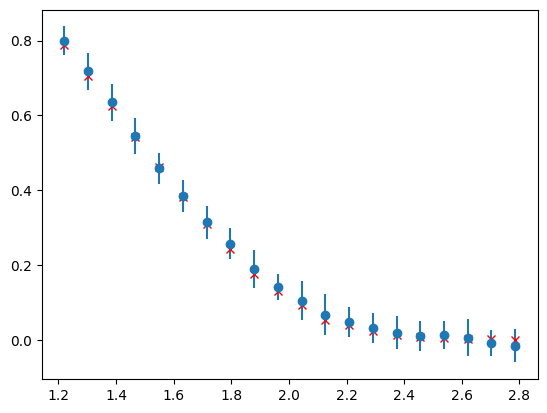

In [107]:
import matplotlib.pyplot as plt
plt.errorbar(all_strike_prices, all_estimates, yerr=all_std, fmt='o')
plt.plot(all_strike_prices, exact_expectations, 'rx')

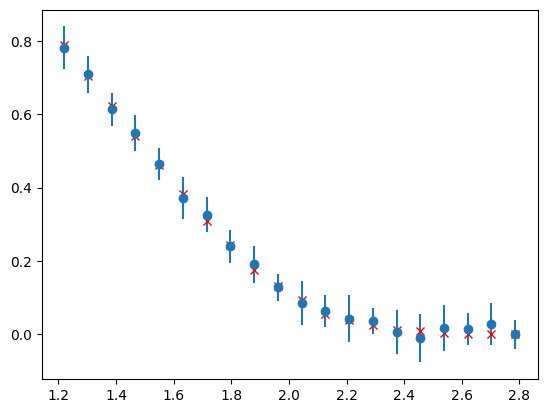

In [84]:
import matplotlib.pyplot as plt
plt.errorbar(all_strike_prices, all_estimates, yerr=all_std, fmt='o')
plt.plot(all_strike_prices, exact_expectations, 'rx')

In [374]:
all_results = []
sampler = Sampler(run_options={"shots": 10000})
for _ in range(30):
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=sampler)
    result = ae.estimate(problem)
    all_results.append(post_processor(result.estimation))
    
print("mean: {}, std: {}".format(np.mean(all_results), np.std(all_results)))

mean: 0.2185821351403541, std: 0.04352371972397902


In [375]:
exact_expectation = 0
for i in range(len(uncertainty_model.probabilities)):
    exact_expectation += uncertainty_model.probabilities[i] * max(uncertainty_model.values[i] - strike_price, 0)

print("Exact value: {}".format(exact_expectation))
print("confidence interval: [{}, {}]".format(post_processor(result.confidence_interval[0]), post_processor(result.confidence_interval[1])))
print("estimated value: {}".format(post_processor(result.estimation)))
print("number of evaluations: {}".format(result.num_oracle_queries))

Exact value: 0.240016643812735
confidence interval: [0.031561277938574696, 0.34720341781125375]
estimated value: 0.18938234787491423
number of evaluations: 160000


0.240016643812735


# Test same random variables, same strike prices

In [5]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(uncertainty_model)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘


In [6]:
for i in range(2**num_uncertainty_qubits):
    print(uncertainty_model.values[i][1])

1.2072834631468483
1.7416187323881238
2.2759540016293993
2.8102892708706744


In [7]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder



def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

strike_price_1 = 1.9
strike_price_2 = 1.9

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

def objective_function(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')

    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price_int(strike_price, high, low, num_uncertainty_qubits)
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    offset = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_int-1))/2
    offset_angle = step*offset
    # circuit.ry(-step*offset*2, objective_register[0])
    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step)
        fmax = high - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor

    
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ

# construct rotater for first strike

first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
first_carry_register = QuantumRegister(1, "carry")

second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
second_carry_register = QuantumRegister(1, "carry2")

comparator_carry = QuantumRegister(1, "comparator_carry")
comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

adder_ancilla = QuantumRegister(1, "adder_ancilla")

objective_register = QuantumRegister(1, "objective")
classical_measurement = ClassicalRegister(1, "c")

subtractor = Subtractor(num_uncertainty_qubits).circuit

circuit = QuantumCircuit(
    first_var_register,
    first_ancilla_register,
    first_carry_register,
    second_var_register,
    second_ancilla_register,
    second_carry_register,
    comparator_carry,
    comparator_ancilla,
    adder_ancilla,
    objective_register,
    classical_measurement,
)


c_approx = 0.05
comparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
# objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
objective, post_processor= objective_function(num_uncertainty_qubits, strike_price_1, c_approx)

controlled_objective = objective.control(num_ctrl_qubits=2, ctrl_state="10")
# controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
# controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="01")


circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])
# circuit.append(uncertainty_model, second_var_register)
circuit.ry(np.pi/2, objective_register)

# offset
# circuit.ry(-offset_angle*2, objective_register[0])

loadNumber(
    circuit,
    first_ancilla_register,
    map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    circuit,
    second_ancilla_register,
    map_strike_price_int(strike_price_2, high, low, num_uncertainty_qubits),
)

circuit.append(
    subtractor,
    first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
)
circuit.append(
    subtractor,
    second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
)
circuit.append(
    comparator,
    first_var_register[:]
    + second_var_register[:]
    + comparator_carry[:]
    + comparator_ancilla[:],
)

circuit.append(
    adder,
    first_var_register[:] + second_var_register[:] + adder_ancilla[:],
)

circuit.append(
    controlled_objective,
    first_carry_register[:] + [comparator_ancilla[0]] + first_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective,
    second_carry_register[:] + [comparator_ancilla[1]] + second_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective,
    first_carry_register[:] + [comparator_ancilla[2]] + first_var_register[:] + objective_register[:],
)

circuit.measure(objective_register, classical_measurement)

circuit.decompose(reps=0).draw()

NameError: name 'Subtractor' is not defined

In [168]:
from qiskit import Aer, execute
num_samples = 1000000
backend = Aer.get_backend('qasm_simulator')
all_results = []
for i in range(50):
    job = execute(circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    # print(counts)
    curr_results = post_processor(counts['1']/num_samples)
    all_results.append(curr_results)

curr_mean = np.mean(all_results)
curr_std = np.std(all_results)

expected_payoff = 0
probabilities = uncertainty_model.probabilities
values = uncertainty_model.values
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print("exact value: {}".format(expected_payoff))
print("mean: {}, std: {}".format(np.mean(all_results), np.std(all_results)))
print("confidence interval: [{}, {}]".format(curr_mean-1.96*curr_std, curr_mean+1.96*curr_std))

exact value: 0.2805408322597011
mean: 0.2687537162417234, std: 0.0426151733733404
confidence interval: [0.1852279764299762, 0.35227945605347055]


In [53]:
expected_payoff = 0
probabilities = uncertainty_model.probabilities
values = uncertainty_model.values
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(expected_payoff)

0.2805408322597011


In [171]:
from tqdm import tqdm
c_approx = 0.01
num_samples = 1000000
# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

strike_prices = np.linspace(low*1.01, high*0.99, 10)

comparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit

def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

def objective_function(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price_int(strike_price, high, low, num_uncertainty_qubits)
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    offset = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_int-1))/2
    # offset = 0
    offset_angle = step*offset * 2
    

    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step)
        fmax = high - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ

all_mean_estimates = []
all_std = []
for strike_price in tqdm(strike_prices):
    first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
    first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
    first_carry_register = QuantumRegister(1, "carry")

    second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
    second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
    second_carry_register = QuantumRegister(1, "carry2")

    comparator_carry = QuantumRegister(1, "comparator_carry")
    comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

    adder_ancilla = QuantumRegister(1, "adder_ancilla")

    objective_register = QuantumRegister(1, "objective")
    classical_measurement = ClassicalRegister(1, "c")

    circuit = QuantumCircuit(
        first_var_register,
        first_ancilla_register,
        first_carry_register,
        second_var_register,
        second_ancilla_register,
        second_carry_register,
        comparator_carry,
        comparator_ancilla,
        adder_ancilla,
        objective_register,
        classical_measurement,
    )

    # objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
    objective, post_processor= objective_function(num_uncertainty_qubits, strike_price, c_approx)

    controlled_objective = objective.control(num_ctrl_qubits=2, ctrl_state="10")
    # controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
    # controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="01")


    circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])
    # circuit.append(uncertainty_model, second_var_register)
    circuit.ry(np.pi/2, objective_register)

    # offset
    # circuit.ry(-offset_angle*2, objective_register[0])

    loadNumber(
        circuit,
        first_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )
    loadNumber(
        circuit,
        second_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )

    circuit.append(
        subtractor,
        first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
    )
    circuit.append(
        subtractor,
        second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
    )
    circuit.append(
        comparator,
        first_var_register[:]
        + second_var_register[:]
        + comparator_carry[:]
        + comparator_ancilla[:],
    )

    circuit.append(
        adder,
        first_var_register[:] + second_var_register[:] + adder_ancilla[:],
    )

    circuit.append(
        controlled_objective,
        first_carry_register[:] + [comparator_ancilla[0]] + first_var_register[:] + objective_register[:],
    )
    circuit.append(
        controlled_objective,
        second_carry_register[:] + [comparator_ancilla[1]] + second_var_register[:] + objective_register[:],
    )
    circuit.append(
        controlled_objective,
        first_carry_register[:] + [comparator_ancilla[2]] + first_var_register[:] + objective_register[:],
    )

    circuit.measure(objective_register, classical_measurement)
    all_results = []
    for i in range(30):
        job = execute(circuit, backend, shots=num_samples)
        result = job.result()
        counts = result.get_counts()
        # print(counts)
        curr_results = post_processor(counts['1']/num_samples)
        all_results.append(curr_results)
    
    curr_mean = np.mean(all_results)
    curr_std = np.std(all_results)
    all_mean_estimates.append(curr_mean)
    all_std.append(curr_std)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:14<00:00, 25.46s/it]


In [172]:
values = uncertainty_model.values
exact_expectations = []
for strike_price in strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(0, values[i][0] - strike_price, values[i][1] - strike_price)
    exact_expectations.append(exact_expectation)

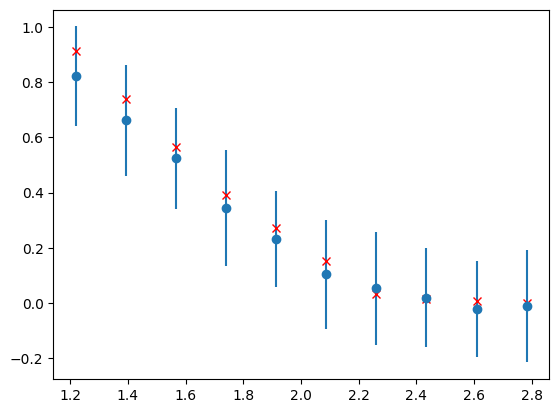

In [173]:
import matplotlib.pyplot as plt
plt.errorbar(strike_prices, all_mean_estimates, yerr = all_std, fmt='o')
# plt.plot(strike_prices, np.array(all_mean_estimates), 'o')
plt.plot(strike_prices, exact_expectations, 'rx')

max(x_1-k_1, x_2-k_1, 0)
x_1, x_2 ~ X

## Test QAE Method

In [9]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder
from qfinance.helper import Subtractor

def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

strike_price = 1.9

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

def objective_function(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price_int(strike_price, high, low, num_uncertainty_qubits)
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    offset = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_int-1))/2
    offset_angle = step*offset * 2

    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step) + offset
        fmax = high - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor, offset_angle

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ

# construct rotater for first strike

first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
first_carry_register = QuantumRegister(1, "carry")

second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
second_carry_register = QuantumRegister(1, "carry2")

comparator_carry = QuantumRegister(1, "comparator_carry")
comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

adder_ancilla = QuantumRegister(1, "adder_ancilla")

objective_register = QuantumRegister(1, "objective")

subtractor = Subtractor(num_uncertainty_qubits).circuit

circuit = QuantumCircuit(
    first_var_register,
    first_ancilla_register,
    first_carry_register,
    second_var_register,
    second_ancilla_register,
    second_carry_register,
    comparator_carry,
    comparator_ancilla,
    adder_ancilla,
    objective_register,
)


c_approx = 0.005
comparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
# objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
objective, post_processor, offset_angle= objective_function(num_uncertainty_qubits, strike_price_1, c_approx)

controlled_objective = objective.control(num_ctrl_qubits=2, ctrl_state="10")

circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])

# set sin(x) to sin(x+pi/4)
circuit.ry(np.pi/2, objective_register)

# offset
circuit.ry(-offset_angle, objective_register[0])

loadNumber(
    circuit,
    first_ancilla_register,
    map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
)
loadNumber(
    circuit,
    second_ancilla_register,
    map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
)

circuit.append(
    subtractor,
    first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
)
circuit.append(
    subtractor,
    second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
)
circuit.append(
    comparator,
    first_var_register[:]
    + second_var_register[:]
    + comparator_carry[:]
    + comparator_ancilla[:],
)

circuit.append(
    adder,
    first_var_register[:] + second_var_register[:] + adder_ancilla[:],
)

circuit.append(
    controlled_objective,
    first_carry_register[:] + [comparator_ancilla[0]] + first_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective,
    second_carry_register[:] + [comparator_ancilla[1]] + second_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective,
    first_carry_register[:] + [comparator_ancilla[2]] + first_var_register[:] + objective_register[:],
)

circuit.decompose(reps=0).draw()

┌───────┐ ┌─────────────┐┌────────┐»
              var1_0: ──────┤0      ├─┤0            ├┤0       ├»
                            │       │ │             ││        │»
              var1_1: ──────┤1      ├─┤1            ├┤1       ├»
                            │       │ │             ││        │»
          ancilla1_0: ──────┤       ├─┤2 subtractor ├┤        ├»
                      ┌───┐ │       │ │             ││        │»
          ancilla1_1: ┤ X ├─┤  P(X) ├─┤3            ├┤        ├»
                      └───┘ │       │ │             ││        │»
               carry: ──────┤       ├─┤4            ├┤        ├»
                            │       │ ├─────────────┤│        │»
              var2_0: ──────┤2      ├─┤0            ├┤2       ├»
                            │       │ │             ││        │»
              var2_1: ──────┤3      ├─┤1            ├┤3       ├»
                            └───────┘ │             ││  QComp │»
          ancilla2_0: ────────────────┤2 subtractor ├┤        ├»
                              ┌───┐   │             ││        │»
          ancilla2_1: ────────┤ X ├───┤3            ├┤        ├»
                              └───┘   │             ││        │»
              carry2: ────────────────┤4            ├┤        ├»
                                      └─────────────┘│        │»
    comparator_carry: ───────────────────────────────┤4       ├»
                                                     │        │»
comparator_ancilla_0: ───────────────────────────────┤5       ├»
                                                     │        │»
comparator_ancilla_1: ───────────────────────────────┤6       ├»
                                                     │        │»
comparator_ancilla_2: ───────────────────────────────┤7       ├»
                                                     └────────┘»
       adder_ancilla: ─────────────────────────────────────────»
                           ┌─────────┐┌─────────────┐          »
           objective: ─────┤ Ry(π/2) ├┤ Ry(-π/2400) ├──────────»
                           └─────────┘└─────────────┘          »
«                      ┌─────────────────┐┌───────────┐             »
«              var1_0: ┤0                ├┤0          ├─────────────»
«                      │                 ││           │             »
«              var1_1: ┤1                ├┤1          ├─────────────»
«                      │                 ││           │             »
«          ancilla1_0: ┤                 ├┤           ├─────────────»
«                      │                 ││           │             »
«          ancilla1_1: ┤                 ├┤           ├─────────────»
«                      │                 ││           │             »
«               carry: ┤                 ├o           ├─────────────»
«                      │                 ││           │┌───────────┐»
«              var2_0: ┤2                ├┤           ├┤0          ├»
«                      │                 ││           ││           │»
«              var2_1: ┤3                ├┤           ├┤1          ├»
«                      │                 ││           ││           │»
«          ancilla2_0: ┤  DraperQFTAdder ├┤           ├┤           ├»
«                      │                 ││  F_custom ││           │»
«          ancilla2_1: ┤                 ├┤           ├┤           ├»
«                      │                 ││           ││           │»
«              carry2: ┤                 ├┤           ├o           ├»
«                      │                 ││           ││           │»
«    comparator_carry: ┤                 ├┤           ├┤  F_custom ├»
«                      │                 ││           ││           │»
«comparator_ancilla_0: ┤                 ├■           ├┤           ├»
«                      │                 ││           ││           │»
«comparator_ancilla_1: ┤                 ├┤           ├■           ├»
«                      │                 ││           ││       

In [56]:
problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[circuit.num_qubits-1],
    post_processing=post_processor
)

epsilon = 0.0001
alpha = 0.01

sampler = Sampler(run_options={"shots": 10000})
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=sampler)
result = ae.estimate(problem)
print(result)

expected_payoff = 0
probabilities = uncertainty_model.probabilities
values = uncertainty_model.values
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_1)

print("exact value: {}".format(expected_payoff))
print("estimated value: {}".format(post_processor(result.estimation)))
print("confidence interval: [{}, {}]".format(post_processor(result.confidence_interval[0]), post_processor(result.confidence_interval[1])))

{   'alpha': 0.01,
    'circuit_results': None,
    'confidence_interval': (0.49969508225092724, 0.4997311761267763),
    'confidence_interval_processed': (0.28539915229017476, 0.31486634246492456),
    'epsilon_estimated': 1.8046937924537376e-05,
    'epsilon_estimated_processed': 0.014733595087374901,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.4772428733083438, 0.5109664564402312],
                              [0.4991616787520079, 0.500183870552705],
                              [0.49969508225092724, 0.4997311761267763]],
    'estimation': 0.4997131291888518,
    'estimation_processed': 0.30013274737757234,
    'num_oracle_queries': 4830000,
    'powers': [0, 0, 16, 467],
    'ratios': [1.0, 33.0, 28.333333333333332],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.12137683913662865, 0.12674550571644078],
                           [0.12486657696697147, 0.1250292639080116],
          

In [10]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(uncertainty_model)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘


In [18]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation
from tqdm import tqdm

c_approx = 0.01
epsilon = 0.001
alpha = 0.01

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

strike_prices = np.linspace(low*1.01, high*0.99, 10)

comparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit

sampler = Sampler(run_options={"shots": 10000})

def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

def objective_function(num_uncertainty_qubits, strike_price, c_approx=0.01):
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    
    mapped_strike_price_float = map_strike_price_float(strike_price, high, low, num_uncertainty_qubits)
    mapped_strike_price_int = map_strike_price_int(strike_price, high, low, num_uncertainty_qubits)
    
    circuit = QuantumCircuit(model_register, objective_register)
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    
    offset = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_int-1))/2
    # offset = 0
    offset_angle = step*offset * 2
    

    circuit.ry(-step*mapped_strike_price_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step) + offset
        fmax = high - strike_price
        og_range = 2**num_uncertainty_qubits - 1 - mapped_strike_price_float
        return coeff/og_range*(fmax)
    
    return circuit.to_gate(label="F_custom"), post_processor, offset_angle

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ

all_mean_estimates = []
all_std = []
for strike_price in tqdm(strike_prices):
    first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
    first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
    first_carry_register = QuantumRegister(1, "carry")

    second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
    second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
    second_carry_register = QuantumRegister(1, "carry2")

    comparator_carry = QuantumRegister(1, "comparator_carry")
    comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

    adder_ancilla = QuantumRegister(1, "adder_ancilla")

    objective_register = QuantumRegister(1, "objective")
    circuit = QuantumCircuit(
        first_var_register,
        first_ancilla_register,
        first_carry_register,
        second_var_register,
        second_ancilla_register,
        second_carry_register,
        comparator_carry,
        comparator_ancilla,
        adder_ancilla,
        objective_register,
    )

    # objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
    objective, post_processor, offset_angle= objective_function(num_uncertainty_qubits, strike_price, c_approx)
    controlled_objective = objective.control(num_ctrl_qubits=2, ctrl_state="10")
    circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])

    # set sin(x) to sin(x+pi/4)
    circuit.ry(np.pi/2, objective_register)
    # offset
    circuit.ry(-offset_angle, objective_register[0])
    loadNumber(
        circuit,
        first_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )
    loadNumber(
        circuit,
        second_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )
    circuit.append(
        subtractor,
        first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
    )
    circuit.append(
        subtractor,
        second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
    )
    circuit.append(
        comparator,
        first_var_register[:]
        + second_var_register[:]
        + comparator_carry[:]
        + comparator_ancilla[:],
    )
    circuit.append(
        adder,
        first_var_register[:] + second_var_register[:] + adder_ancilla[:],
    )
    circuit.append(
        controlled_objective,
        first_carry_register[:] + [comparator_ancilla[0]] + first_var_register[:] + objective_register[:],
    )
    circuit.append(
        controlled_objective,
        second_carry_register[:] + [comparator_ancilla[1]] + second_var_register[:] + objective_register[:],
    )
    circuit.append(
        controlled_objective,
        first_carry_register[:] + [comparator_ancilla[2]] + first_var_register[:] + objective_register[:],
    )
    problem = EstimationProblem(
        state_preparation=circuit,
        objective_qubits=[circuit.num_qubits -1],
        post_processing=post_processor
    )
    
    # ae = MaximumLikelihoodAmplitudeEstimation(
    #     [0,1,2,4,8,16,32,64], sampler = sampler
    # )
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=sampler)
    result = ae.estimate(problem)
    print("raw estimate {}".format(result.estimation))
    print("epsilon_processed {}".format(result.epsilon_estimated_processed))
    print("post processed estimate {}".format(post_processor(result.estimation)))
    print()
    all_mean_estimates.append(result.estimation_processed)
    all_std.append(result.confidence_interval_processed)


 10%|█         | 1/10 [00:04<00:38,  4.25s/it]

raw estimate 0.500141906887508
epsilon_processed 0.2172783982625464
post processed estimate 0.8594295900785905



 20%|██        | 2/10 [00:06<00:25,  3.24s/it]

raw estimate 0.49989034524722975
epsilon_processed 0.21727839200462112
post processed estimate 0.7567416060318138



 30%|███       | 3/10 [00:10<00:23,  3.43s/it]

raw estimate 0.49936145556826494
epsilon_processed 0.14331191863213352
post processed estimate 0.540847740592065



 40%|████      | 4/10 [00:14<00:22,  3.73s/it]

raw estimate 0.49865680174533455
epsilon_processed 0.21727978029443906
post processed estimate 0.253206586529269



 50%|█████     | 5/10 [00:20<00:21,  4.33s/it]

raw estimate 0.49952437157962454
epsilon_processed 0.16428395518910544
post processed estimate 0.34018276017956334



 60%|██████    | 6/10 [00:24<00:17,  4.45s/it]

raw estimate 0.49930272990346924
epsilon_processed 0.19244705078679172
post processed estimate 0.249708167630565



 70%|███████   | 7/10 [00:28<00:12,  4.29s/it]

raw estimate 0.49863176907811735
epsilon_processed 0.20411164710895632
post processed estimate -0.024179434841451602



 80%|████████  | 8/10 [00:32<00:08,  4.22s/it]

raw estimate 0.499409067872652
epsilon_processed 0.2041103063844484
post processed estimate 0.025947912890758096



 90%|█████████ | 9/10 [00:36<00:04,  4.22s/it]

raw estimate 0.49928170330066624
epsilon_processed 0.20411045267757116
post processed estimate -0.026042569925817445



100%|██████████| 10/10 [00:41<00:00,  4.13s/it]

raw estimate 0.4995290663738836
epsilon_processed 0.2172785538666923
post processed estimate 0.07493155032641186



In [19]:
print(strike_prices)
print(all_mean_estimates)
print(all_std)

[1.2193563  1.39300408 1.56665187 1.74029966 1.91394744 2.08759523
 2.26124302 2.4348908  2.60853859 2.78218638]
[0.8594295900785905, 0.7567416060318138, 0.540847740592065, 0.253206586529269, 0.34018276017956334, 0.249708167630565, -0.024179434841451602, 0.025947912890758096, -0.026042569925817445, 0.07493155032641186]
[(0.6421511918160555, 1.0767079883411483), (0.5394632140271813, 0.9740199980364236), (0.39753582195993137, 0.6841596592241984), (0.03592680623484123, 0.47048636682371936), (0.17589880499045785, 0.5044667153686687), (0.05726111684377326, 0.4421552184173567), (-0.2282910819504193, 0.17993221226749334), (-0.1781623934936903, 0.2300582192752065), (-0.23015302260337725, 0.17806788275176505), (-0.14234700354029178, 0.2922101041930928)]


In [20]:
values = uncertainty_model.values
exact_expectations = []
for strike_price in strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(0, values[i][0] - strike_price, values[i][1] - strike_price)
    exact_expectations.append(exact_expectation)

In [21]:
print(uncertainty_model.probabilities)
print(values)

[1.11800529e-06 5.86120788e-04 4.49587029e-04 2.05318709e-05
 5.86120788e-04 3.07277238e-01 2.35698619e-01 1.07639529e-02
 4.49587029e-04 2.35698619e-01 1.80793864e-01 8.25654665e-03
 2.05318709e-05 1.07639529e-02 8.25654665e-03 3.77062368e-04]
[(1.2072834631468483, 1.2072834631468483), (1.2072834631468483, 1.7416187323881238), (1.2072834631468483, 2.2759540016293993), (1.2072834631468483, 2.8102892708706744), (1.7416187323881238, 1.2072834631468483), (1.7416187323881238, 1.7416187323881238), (1.7416187323881238, 2.2759540016293993), (1.7416187323881238, 2.8102892708706744), (2.2759540016293993, 1.2072834631468483), (2.2759540016293993, 1.7416187323881238), (2.2759540016293993, 2.2759540016293993), (2.2759540016293993, 2.8102892708706744), (2.8102892708706744, 1.2072834631468483), (2.8102892708706744, 1.7416187323881238), (2.8102892708706744, 2.2759540016293993), (2.8102892708706744, 2.8102892708706744)]


In [22]:
all_std
error_bars = np.array(all_std).T
lower_bars = all_mean_estimates - error_bars[0]
upper_bars = error_bars[1] - all_mean_estimates
asymmetric_error = [lower_bars, upper_bars]



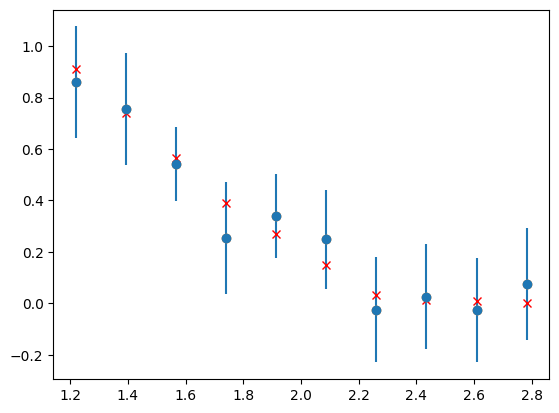

In [24]:
import matplotlib.pyplot as plt
plt.errorbar(strike_prices, all_mean_estimates, yerr = asymmetric_error, fmt='o')
plt.plot(strike_prices, np.array(all_mean_estimates), 'o')
plt.plot(strike_prices, exact_expectations, 'rx')

# Same variable, different strike prices

In [25]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder

c_approx = 0.01
epsilon = 0.001
alpha = 0.01

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

strike_price_1 = 1.9
strike_price_2 = 1.6

comparator = QComp(num_uncertainty_qubits, num_uncertainty_qubits)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit

sampler = Sampler(run_options={"shots": 10000})

def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)))

def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)

def objective_function_two_strike(num_uncertainty_qubits, strike_price_1, strike_price_2, c_approx=0.01):
    
    # map strike prices
    mapped_strike_price_1_float = map_strike_price_float(strike_price_1, high, low, num_uncertainty_qubits)
    mapped_strike_price_1_int = map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits)
    
    mapped_strike_price_2_float = map_strike_price_float(strike_price_2, high, low, num_uncertainty_qubits)
    mapped_strike_price_2_int = map_strike_price_int(strike_price_2, high, low, num_uncertainty_qubits)
    
    step = (np.pi/8) / (2**num_uncertainty_qubits-1) * c_approx
    # determine offset
    offset_1 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_1_int-1))/2
    offset_2 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_2_int-1))/2
    
    offset = max(offset_1, offset_2)
    offset_angle = step*offset * 2
    
    
    # create first payoff function
    model_register = QuantumRegister(num_uncertainty_qubits, 'model')
    objective_register = QuantumRegister(1, 'objective')
    
    circuit_one = QuantumCircuit(model_register, objective_register)
    circuit_one.ry(-step*mapped_strike_price_1_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_one.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    # Create second_payoff_function
    circuit_two = QuantumCircuit(model_register, objective_register)
    circuit_two.ry(-step*mapped_strike_price_2_float*2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_two.cry(step*2**(i+1), model_register[i], objective_register[0])
    
    def post_processor(prob_of_one):
        coeff = (prob_of_one-0.5)/(step) + offset
        fmax = high - min(strike_price_1, strike_price_2)
        og_range = 2**num_uncertainty_qubits - 1 - min(mapped_strike_price_1_float, mapped_strike_price_2_float)
        return coeff/og_range*(fmax)
    
    return circuit_one.to_gate(label="F1"), circuit_two.to_gate(label="F2"), post_processor, offset_angle

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ

first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
first_carry_register = QuantumRegister(1, "carry")

second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
second_carry_register = QuantumRegister(1, "carry2")

comparator_carry = QuantumRegister(1, "comparator_carry")
comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

adder_ancilla = QuantumRegister(1, "adder_ancilla")

objective_register = QuantumRegister(1, "objective")
circuit = QuantumCircuit(
    first_var_register,
    first_ancilla_register,
    first_carry_register,
    second_var_register,
    second_ancilla_register,
    second_carry_register,
    comparator_carry,
    comparator_ancilla,
    adder_ancilla,
    objective_register,
)

# objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
objective_1, objective_2, post_processor, offset_angle= objective_function_two_strike(num_uncertainty_qubits, strike_price_1, strike_price_2, c_approx)

controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="10")

circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])

# set sin(x) to sin(x+pi/4)
circuit.ry(np.pi/2, objective_register)
# offset
circuit.ry(-offset_angle, objective_register[0])

# load strike prices
loadNumber(
    circuit,
    first_ancilla_register,
    map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    circuit,
    second_ancilla_register,
    map_strike_price_int(strike_price_2, high, low, num_uncertainty_qubits),
)
circuit.append(
    subtractor,
    first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
)
circuit.append(
    subtractor,
    second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
)
circuit.append(
    comparator,
    first_var_register[:]
    + second_var_register[:]
    + comparator_carry[:]
    + comparator_ancilla[:],
)
circuit.append(
    adder,
    first_var_register[:] + second_var_register[:] + adder_ancilla[:],
)
circuit.append(
    controlled_objective_1,
    first_carry_register[:] + [comparator_ancilla[0]] + first_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective_2,
    second_carry_register[:] + [comparator_ancilla[1]] + second_var_register[:] + objective_register[:],
)
circuit.append(
    controlled_objective_1,
    first_carry_register[:] + [comparator_ancilla[2]] + first_var_register[:] + objective_register[:],
)
circuit.draw()

┌───────┐               ┌─────────────┐┌────────┐»
              var1_0: ─┤0      ├───────────────┤0            ├┤0       ├»
                       │       │               │             ││        │»
              var1_1: ─┤1      ├───────────────┤1            ├┤1       ├»
                       │       │               │             ││        │»
          ancilla1_0: ─┤       ├───────────────┤2 subtractor ├┤        ├»
                       │       │     ┌───┐     │             ││        │»
          ancilla1_1: ─┤  P(X) ├─────┤ X ├─────┤3            ├┤        ├»
                       │       │     └───┘     │             ││        │»
               carry: ─┤       ├───────────────┤4            ├┤        ├»
                       │       │               ├─────────────┤│        │»
              var2_0: ─┤2      ├───────────────┤0            ├┤2       ├»
                       │       │               │             ││        │»
              var2_1: ─┤3      ├───────────────┤1            ├┤3       ├»
                       └───────┘     ┌───┐     │             ││  QComp │»
          ancilla2_0: ───────────────┤ X ├─────┤2 subtractor ├┤        ├»
                                     └───┘     │             ││        │»
          ancilla2_1: ─────────────────────────┤3            ├┤        ├»
                                               │             ││        │»
              carry2: ─────────────────────────┤4            ├┤        ├»
                                               └─────────────┘│        │»
    comparator_carry: ────────────────────────────────────────┤4       ├»
                                                              │        │»
comparator_ancilla_0: ────────────────────────────────────────┤5       ├»
                                                              │        │»
comparator_ancilla_1: ────────────────────────────────────────┤6       ├»
                                                              │        │»
comparator_ancilla_2: ────────────────────────────────────────┤7       ├»
                                                              └────────┘»
       adder_ancilla: ──────────────────────────────────────────────────»
                      ┌─────────┐┌────────────┐                         »
           objective: ┤ Ry(π/2) ├┤ Ry(-π/800) ├─────────────────────────»
                      └─────────┘└────────────┘                         »
«                      ┌─────────────────┐┌─────┐       ┌─────┐
«              var1_0: ┤0                ├┤0    ├───────┤0    ├
«                      │                 ││     │       │     │
«              var1_1: ┤1                ├┤1    ├───────┤1    ├
«                      │                 ││     │       │     │
«          ancilla1_0: ┤                 ├┤     ├───────┤     ├
«                      │                 ││     │       │     │
«          ancilla1_1: ┤                 ├┤     ├───────┤     ├
«                      │                 ││     │       │     │
«               carry: ┤                 ├o     ├───────o     ├
«                      │                 ││     │┌─────┐│     │
«              var2_0: ┤2                ├┤     ├┤0    ├┤     ├
«                      │                 ││     ││     ││     │
«              var2_1: ┤3                ├┤     ├┤1    ├┤     ├
«                      │                 ││     ││     ││     │
«          ancilla2_0: ┤  DraperQFTAdder ├┤     ├┤     ├┤     ├
«                      │                 ││  F1 ││     ││  F1 │
«          ancilla2_1: ┤                 ├┤     ├┤     ├┤     ├
«                      │                 ││     ││     ││     │
«              carry2: ┤                 ├┤     ├o     ├┤     ├
«                      │                 ││     ││     ││     │
«    comparator_carry: ┤                 ├┤     ├┤  F2 ├┤     ├
«                      │                 ││     ││     ││     │
«comparator_ancilla_0: ┤                 ├■     ├┤     ├┤     ├
«                      │                 ││  

In [26]:
problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[circuit.num_qubits -1],
    post_processing=post_processor
)
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=sampler)
result = ae.estimate(problem)
print(result)


{   'alpha': 0.01,
    'circuit_results': None,
    'confidence_interval': (0.49826144432049935, 0.4992043505966898),
    'confidence_interval_processed': (0.0918208645672833, 0.4767171648932887),
    'epsilon_estimated': 0.00047145313809524025,
    'epsilon_estimated_processed': 0.1924481501630027,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.48869921448080633, 0.5216929004929601],
                              [0.49826144432049935, 0.4992043505966898]],
    'estimation': 0.4987328974585946,
    'estimation_processed': 0.2842690147302973,
    'num_oracle_queries': 170000,
    'powers': [0, 0, 17],
    'ratios': [1.0, 35.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.1232012709605319, 0.12845361639484268],
                           [0.1247232997122, 0.1248733684110516]]}


In [27]:
exact_expectation = 0
for i in range(len(uncertainty_model.probabilities)):
    exact_expectation += uncertainty_model.probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(exact_expectation)
print(result.estimation_processed)
print(result.confidence_interval_processed)

0.45504810022256087
0.2842690147302973
(0.0918208645672833, 0.4767171648932887)


## fixed number

In [37]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(uncertainty_model)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘


In [55]:
print([value[1] for value in uncertainty_model.values[0:8]])

[1.2072834631468483, 1.4362842928216806, 1.6652851224965128, 1.8942859521713453, 2.1232867818461774, 2.35228761152101, 2.5812884411958423, 2.8102892708706744]


In [106]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder
from tqdm import tqdm

c_approx = 0.01
epsilon = 0.001
alpha = 0.01

num_samples = 1000000
# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)
adder = DraperQFTAdder(num_uncertainty_qubits+1, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit


def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(
        np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))
    )


def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)


def objective_function_two_strike(
    num_uncertainty_qubits, strike_price_1, strike_price_2, c_approx=0.01
):

    # map strike prices
    mapped_strike_price_1_float = map_strike_price_float(
        strike_price_1, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_1_int = map_strike_price_int(
        strike_price_1, high, low, num_uncertainty_qubits
    )

    mapped_strike_price_2_float = map_strike_price_float(
        strike_price_2, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_2_int = map_strike_price_int(
        strike_price_2, high, low, num_uncertainty_qubits
    )

    step = (np.pi / 8) / (2**num_uncertainty_qubits - 1) * c_approx
    # determine offset
    offset_1 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_1_int - 1)) / 2
    offset_2 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_2_int - 1)) / 2

    offset = np.mean([offset_1, offset_2])
    # offset = 0
    offset_angle = step * offset * 2

    # create first payoff function
    model_register = QuantumRegister(num_uncertainty_qubits, "model")
    objective_register = QuantumRegister(1, "objective")

    circuit_one = QuantumCircuit(model_register, objective_register)
    circuit_one.ry(-step * mapped_strike_price_1_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_one.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    # Create second_payoff_function
    circuit_two = QuantumCircuit(model_register, objective_register)
    circuit_two.ry(-step * mapped_strike_price_2_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_two.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    def post_processor(prob_of_one):
        coeff = (prob_of_one - 0.5) / (step) + offset
        fmax = high - min(strike_price_1, strike_price_2)
        og_range = (
            2**num_uncertainty_qubits
            - 1
            - min(mapped_strike_price_1_float, mapped_strike_price_2_float)
        )
        return coeff / og_range * (fmax)

    return (
        circuit_one.to_gate(label="F1"),
        circuit_two.to_gate(label="F2"),
        post_processor,
        offset_angle,
    )


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ


# fixed numbers
first_number = 3
second_number = 6
strike_price_1 = 1.9
strike_price = 1.2

first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
first_carry_register = QuantumRegister(1, "carry")

second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
second_carry_register = QuantumRegister(1, "carry2")
second_carry_register_copy = QuantumRegister(1, "carry2_copy")

comparator_carry = QuantumRegister(1, "comparator_carry")
comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

adder_ancilla = QuantumRegister(1, "adder_ancilla")

objective_register = QuantumRegister(1, "objective")
classical_measurement = ClassicalRegister(1, "classical_measurement")
circuit = QuantumCircuit(
    first_var_register,
    first_ancilla_register,
    first_carry_register,
    second_var_register,
    second_ancilla_register,
    second_carry_register,
    second_carry_register_copy,
    comparator_carry,
    comparator_ancilla,
    objective_register,
    classical_measurement,
)

# objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
objective_1, objective_2, post_processor, offset_angle = objective_function_two_strike(
    num_uncertainty_qubits, strike_price_1, strike_price, c_approx
)

controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="10")

# set sin(x) to sin(x+pi/4)
circuit.ry(np.pi / 2, objective_register)
# offset
circuit.ry(-offset_angle, objective_register[0])


# load numbers
loadNumber(
    circuit,
    first_var_register,
    first_number,
)
loadNumber(
    circuit,
    second_var_register,
    second_number,
)

# load strike prices
loadNumber(
    circuit,
    first_ancilla_register,
    map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits),
)
loadNumber(
    circuit,
    second_ancilla_register,
    map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
)
circuit.append(
    subtractor,
    first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
)
circuit.append(
    subtractor,
    second_var_register[:] + second_ancilla_register[:] + [second_carry_register[0]],
)
circuit.cx(second_carry_register[0], second_carry_register_copy[0])
circuit.append(
    comparator,
    first_ancilla_register[:]
    + first_carry_register[:]
    + second_ancilla_register[:]
    + second_carry_register[:]
    + comparator_carry[:]
    + comparator_ancilla[:],
)
# circuit.append(
#     adder,
#     first_ancilla_register[:] 
#     + first_carry_register[:]
#     + second_ancilla_register[:]
#     + second_carry_register[:]
#     + adder_ancilla[:],
# )
circuit.append(
    controlled_objective_2,
    second_carry_register_copy[:]
    + [comparator_ancilla[0]]
    + second_var_register[:]
    + objective_register[:],
)
circuit.append(
    controlled_objective_1,
    first_carry_register[:]
    + [comparator_ancilla[1]]
    + first_var_register[:]
    + objective_register[:],
)
circuit.append(
    controlled_objective_1,
    first_carry_register[:]
    + [comparator_ancilla[2]]
    + first_var_register[:]
    + objective_register[:],
)
circuit.measure(objective_register, classical_measurement)
circuit.draw()


┌───┐    ┌─────────────┐                        »
                 var1_0: ───┤ X ├────┤0            ├────────────────────────»
                            ├───┤    │             │                        »
                 var1_1: ───┤ X ├────┤1            ├────────────────────────»
                            └───┘    │             │                        »
                 var1_2: ────────────┤2            ├────────────────────────»
                                     │             │      ┌─────────┐       »
             ancilla1_0: ────────────┤3 subtractor ├──────┤0        ├───────»
                                     │             │      │         │       »
             ancilla1_1: ────────────┤4            ├──────┤1        ├───────»
                            ┌───┐    │             │      │         │       »
             ancilla1_2: ───┤ X ├────┤5            ├──────┤2        ├───────»
                            └───┘    │             │      │         │       »
                  carry: ────────────┤6            ├──────┤3        ├───────»
                                     ├─────────────┤      │         │┌─────┐»
                 var2_0: ────────────┤0            ├──────┤         ├┤0    ├»
                            ┌───┐    │             │      │         ││     │»
                 var2_1: ───┤ X ├────┤1            ├──────┤         ├┤1    ├»
                            ├───┤    │             │      │         ││     │»
                 var2_2: ───┤ X ├────┤2            ├──────┤         ├┤2    ├»
                            └───┘    │             │      │         ││     │»
             ancilla2_0: ────────────┤3 subtractor ├──────┤4        ├┤     ├»
                                     │             │      │   QComp ││     │»
             ancilla2_1: ────────────┤4            ├──────┤5        ├┤     ├»
                                     │             │      │         ││     │»
             ancilla2_2: ────────────┤5            ├──────┤6        ├┤     ├»
                                     │             │      │         ││     │»
                 carry2: ────────────┤6            ├───■──┤7        ├┤  F2 ├»
                                     └─────────────┘ ┌─┴─┐│         ││     │»
            carry2_copy: ────────────────────────────┤ X ├┤         ├o     ├»
                                                     └───┘│         ││     │»
       comparator_carry: ─────────────────────────────────┤8        ├┤     ├»
                                                          │         ││     │»
   comparator_ancilla_0: ─────────────────────────────────┤9        ├■     ├»
                                                          │         ││     │»
   comparator_ancilla_1: ─────────────────────────────────┤10       ├┤     ├»
                                                          │         ││     │»
   comparator_ancilla_2: ─────────────────────────────────┤11       ├┤     ├»
                         ┌─────────┐┌───────────────┐     └─────────┘│     │»
              objective: ┤ Ry(π/2) ├┤ Ry(-0.003366) ├────────────────┤3    ├»
                         └─────────┘└───────────────┘                └─────┘»
classical_measurement: 1/═══════════════════════════════════════════════════»
                                                                            »
«                         ┌─────┐┌─────┐   
«                 var1_0: ┤0    ├┤0    ├───
«                         │     ││     │   
«                 var1_1: ┤1    ├┤1    ├───
«                         │     ││     │   
«                 var1_2: ┤2    ├┤2    ├───
«                         │     ││     │   
«             ancilla1_0: ┤     ├┤     ├───
«                         │     ││     │   
«             ancilla1_1: ┤     ├┤     ├───
«                         │     ││     │   
«             ancilla1_2: ┤     ├┤     ├───
«                         │     ││     │   
«                  carry: o     ├o     ├───
«                         │     ││     │   
«             

In [107]:
all_results = []
for i in range(30):
    job = execute(circuit, backend, shots=num_samples)
    result = job.result()
    counts = result.get_counts()
    # print(counts)
    curr_results = post_processor(counts["1"] / num_samples)
    all_results.append(curr_results)

curr_mean = np.mean(all_results)
curr_std = np.std(all_results)

In [108]:
all_values = [value[1] for value in uncertainty_model.values[0:8]]
exact_expectation = max(0, all_values[first_number] - strike_price_1, all_values[second_number] - strike_price)

In [109]:
print("exact expectation: {}".format(exact_expectation))
print("estimated expectation: {}".format(curr_mean))
print("confidence interval: [{}, {}]".format(curr_mean - 1.96*curr_std, curr_mean + 1.96*curr_std))

exact expectation: 1.3812884411958424
estimated expectation: 1.3693122606745411
confidence interval: [1.022276140738899, 1.7163483806101834]


## Brute force sampling

In [110]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder
from tqdm import tqdm

c_approx = 0.01

num_samples = 1000000
# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev


strike_price_1 = 1.9
strike_prices = np.linspace(low * 1.01, high * 0.99, 10)

comparator = QComp(num_uncertainty_qubits + 1, num_uncertainty_qubits + 1)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit


def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(
        np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))
    )


def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)


def objective_function_two_strike(
    num_uncertainty_qubits, strike_price_1, strike_price_2, c_approx=0.01
):

    # map strike prices
    mapped_strike_price_1_float = map_strike_price_float(
        strike_price_1, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_1_int = map_strike_price_int(
        strike_price_1, high, low, num_uncertainty_qubits
    )

    mapped_strike_price_2_float = map_strike_price_float(
        strike_price_2, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_2_int = map_strike_price_int(
        strike_price_2, high, low, num_uncertainty_qubits
    )

    step = (np.pi / 8) / (2**num_uncertainty_qubits - 1) * c_approx
    # determine offset
    offset_1 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_1_int - 1)) / 2
    offset_2 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_2_int - 1)) / 2

    offset = np.mean([offset_1, offset_2])
    # offset = 0
    offset_angle = step * offset * 2

    # create first payoff function
    model_register = QuantumRegister(num_uncertainty_qubits, "model")
    objective_register = QuantumRegister(1, "objective")

    circuit_one = QuantumCircuit(model_register, objective_register)
    circuit_one.ry(-step * mapped_strike_price_1_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_one.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    # Create second_payoff_function
    circuit_two = QuantumCircuit(model_register, objective_register)
    circuit_two.ry(-step * mapped_strike_price_2_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_two.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    def post_processor(prob_of_one):
        coeff = (prob_of_one - 0.5) / (step) + offset
        fmax = high - min(strike_price_1, strike_price_2)
        og_range = (
            2**num_uncertainty_qubits
            - 1
            - min(mapped_strike_price_1_float, mapped_strike_price_2_float)
        )
        return coeff / og_range * (fmax)

    return (
        circuit_one.to_gate(label="F1"),
        circuit_two.to_gate(label="F2"),
        post_processor,
        offset_angle,
    )


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ


all_mean_estimates = []
all_std = []


for strike_price in tqdm(strike_prices):
    first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
    first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
    first_carry_register = QuantumRegister(1, "carry")

    second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
    second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
    second_carry_register = QuantumRegister(1, "carry2")
    second_carry_register_copy = QuantumRegister(1, "carry2_copy")

    comparator_carry = QuantumRegister(1, "comparator_carry")
    comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

    adder_ancilla = QuantumRegister(1, "adder_ancilla")

    objective_register = QuantumRegister(1, "objective")
    classical_measurement = ClassicalRegister(1, "classical_measurement")
    circuit = QuantumCircuit(
        first_var_register,
        first_ancilla_register,
        first_carry_register,
        second_var_register,
        second_ancilla_register,
        second_carry_register,
        second_carry_register_copy,
        comparator_carry,
        comparator_ancilla,
        objective_register,
        classical_measurement,
    )

    # objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
    objective_1, objective_2, post_processor, offset_angle = (
        objective_function_two_strike(
            num_uncertainty_qubits, strike_price_1, strike_price, c_approx
        )
    )

    controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
    controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="10")

    circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])

    # set sin(x) to sin(x+pi/4)
    circuit.ry(np.pi / 2, objective_register)
    # offset
    circuit.ry(-offset_angle, objective_register[0])

    # load strike prices
    loadNumber(
        circuit,
        first_ancilla_register,
        map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits),
    )
    loadNumber(
        circuit,
        second_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )
    circuit.append(
        subtractor,
        first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
    )
    circuit.append(
        subtractor,
        second_var_register[:]
        + second_ancilla_register[:]
        + [second_carry_register[0]],
    )
    circuit.cx(second_carry_register[0], second_carry_register_copy[0])
    circuit.append(
        comparator,
        first_ancilla_register[:]
        + first_carry_register[:]
        + second_ancilla_register[:]
        + second_carry_register[:]
        + comparator_carry[:]
        + comparator_ancilla[:],
    )
    # circuit.append(
    #     adder,
    #     first_var_register[:] + second_var_register[:] + adder_ancilla[:],
    # )
    circuit.append(
        controlled_objective_2,
        second_carry_register_copy[:]
        + [comparator_ancilla[0]]
        + second_var_register[:]
        + objective_register[:],
    )
    circuit.append(
        controlled_objective_1,
        first_carry_register[:]
        + [comparator_ancilla[1]]
        + first_var_register[:]
        + objective_register[:],
    )
    circuit.append(
        controlled_objective_1,
        first_carry_register[:]
        + [comparator_ancilla[2]]
        + first_var_register[:]
        + objective_register[:],
    )
    circuit.measure(objective_register, classical_measurement)
    all_results = []
    for i in range(30):
        job = execute(circuit, backend, shots=num_samples)
        result = job.result()
        counts = result.get_counts()
        # print(counts)
        curr_results = post_processor(counts["1"] / num_samples)
        all_results.append(curr_results)

    curr_mean = np.mean(all_results)
    curr_std = np.std(all_results)
    all_mean_estimates.append(curr_mean)
    all_std.append(curr_std)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:48<00:00, 40.88s/it]


In [111]:
values = uncertainty_model.values
exact_expectations = []
for strike_price in strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price)
    exact_expectations.append(exact_expectation)

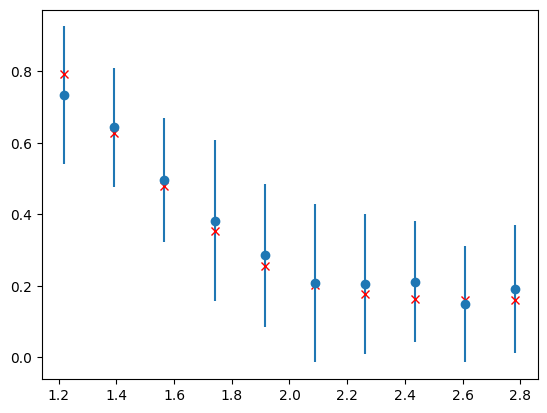

In [112]:
import matplotlib.pyplot as plt
plt.errorbar(strike_prices, all_mean_estimates, yerr = all_std, fmt='o')
# plt.plot(strike_prices, np.array(all_mean_estimates), 'o')
plt.plot(strike_prices, exact_expectations, 'rx')

In [117]:
from qfinance.qArithmetic import QComp
from qiskit.circuit.library import DraperQFTAdder
from tqdm import tqdm

c_approx = 0.01
epsilon = 0.001
alpha = 0.01

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

strike_price_1 = 1.9
strike_prices = np.linspace(low * 1.01, high * 0.99, 10)

comparator = QComp(num_uncertainty_qubits+1, num_uncertainty_qubits+1)
adder = DraperQFTAdder(num_uncertainty_qubits, kind="half")
subtractor = Subtractor(num_uncertainty_qubits).circuit

sampler = Sampler(run_options={"shots": 10000})


def map_strike_price_int(strike_price, high, low, num_uncertainty_qubits):
    return int(
        np.ceil((strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1))
    )


def map_strike_price_float(strike_price, high, low, num_uncertainty_qubits):
    return (strike_price - low) / (high - low) * (2**num_uncertainty_qubits - 1)


def objective_function_two_strike(
    num_uncertainty_qubits, strike_price_1, strike_price_2, c_approx=0.01
):

    # map strike prices
    mapped_strike_price_1_float = map_strike_price_float(
        strike_price_1, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_1_int = map_strike_price_int(
        strike_price_1, high, low, num_uncertainty_qubits
    )

    mapped_strike_price_2_float = map_strike_price_float(
        strike_price_2, high, low, num_uncertainty_qubits
    )
    mapped_strike_price_2_int = map_strike_price_int(
        strike_price_2, high, low, num_uncertainty_qubits
    )

    step = (np.pi / 8) / (2**num_uncertainty_qubits - 1) * c_approx
    # determine offset
    offset_1 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_1_int - 1)) / 2
    offset_2 = (2**num_uncertainty_qubits - 1 - (mapped_strike_price_2_int - 1)) / 2

    offset = np.mean([offset_1, offset_2])
    # offset = 0
    offset_angle = step * offset * 2

    # create first payoff function
    model_register = QuantumRegister(num_uncertainty_qubits, "model")
    objective_register = QuantumRegister(1, "objective")

    circuit_one = QuantumCircuit(model_register, objective_register)
    circuit_one.ry(-step * mapped_strike_price_1_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_one.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    # Create second_payoff_function
    circuit_two = QuantumCircuit(model_register, objective_register)
    circuit_two.ry(-step * mapped_strike_price_2_float * 2, objective_register[0])
    for i in range(num_uncertainty_qubits):
        circuit_two.cry(step * 2 ** (i + 1), model_register[i], objective_register[0])

    def post_processor(prob_of_one):
        coeff = (prob_of_one - 0.5) / (step) + offset
        fmax = high - min(strike_price_1, strike_price_2)
        og_range = (
            2**num_uncertainty_qubits
            - 1
            - min(mapped_strike_price_1_float, mapped_strike_price_2_float)
        )
        return coeff / og_range * (fmax)

    return (
        circuit_one.to_gate(label="F1"),
        circuit_two.to_gate(label="F2"),
        post_processor,
        offset_angle,
    )


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = bin(number)[2:].zfill(register.size)
    # print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == "1":
            circ.x(register[i])
    return circ


all_mean_estimates = []
all_std = []

for strike_price in tqdm(strike_prices):
    first_var_register = QuantumRegister(num_uncertainty_qubits, "var1")
    first_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla1")
    first_carry_register = QuantumRegister(1, "carry")

    second_var_register = QuantumRegister(num_uncertainty_qubits, "var2")
    second_ancilla_register = QuantumRegister(num_uncertainty_qubits, "ancilla2")
    second_carry_register = QuantumRegister(1, "carry2")
    second_carry_register_copy = QuantumRegister(1, "carry2_copy")

    comparator_carry = QuantumRegister(1, "comparator_carry")
    comparator_ancilla = QuantumRegister(3, "comparator_ancilla")

    adder_ancilla = QuantumRegister(1, "adder_ancilla")

    objective_register = QuantumRegister(1, "objective")
    circuit = QuantumCircuit(
        first_var_register,
        first_ancilla_register,
        first_carry_register,
        second_var_register,
        second_ancilla_register,
        second_carry_register,
        second_carry_register_copy,
        comparator_carry,
        comparator_ancilla,
        objective_register,
    )

    # objective_fn, post_processor = basic_function_loader(num_uncertainty_qubits, c_approx)
    objective_1, objective_2, post_processor, offset_angle = (
        objective_function_two_strike(
            num_uncertainty_qubits, strike_price_1, strike_price, c_approx
        )
    )

    controlled_objective_1 = objective_1.control(num_ctrl_qubits=2, ctrl_state="10")
    controlled_objective_2 = objective_2.control(num_ctrl_qubits=2, ctrl_state="10")

    circuit.append(uncertainty_model, first_var_register[:] + second_var_register[:])

    # set sin(x) to sin(x+pi/4)
    circuit.ry(np.pi / 2, objective_register)
    # offset
    circuit.ry(-offset_angle, objective_register[0])

    # load strike prices
    loadNumber(
        circuit,
        first_ancilla_register,
        map_strike_price_int(strike_price_1, high, low, num_uncertainty_qubits),
    )
    loadNumber(
        circuit,
        second_ancilla_register,
        map_strike_price_int(strike_price, high, low, num_uncertainty_qubits),
    )
    circuit.append(
        subtractor,
        first_var_register[:] + first_ancilla_register[:] + [first_carry_register[0]],
    )
    circuit.append(
        subtractor,
        second_var_register[:]
        + second_ancilla_register[:]
        + [second_carry_register[0]],
    )
    circuit.cx(second_carry_register[0], second_carry_register_copy[0])
    circuit.append(
        comparator,
        first_ancilla_register[:]
        + first_carry_register[:]
        + second_ancilla_register[:]
        + second_carry_register[:]
        + comparator_carry[:]
        + comparator_ancilla[:],
    )
    # circuit.append(
    #     adder,
    #     first_var_register[:] + second_var_register[:] + adder_ancilla[:],
    # )
    circuit.append(
        controlled_objective_2,
        second_carry_register_copy[:]
        + [comparator_ancilla[0]]
        + second_var_register[:]
        + objective_register[:],
    )
    circuit.append(
        controlled_objective_1,
        first_carry_register[:]
        + [comparator_ancilla[1]]
        + first_var_register[:]
        + objective_register[:],
    )
    circuit.append(
        controlled_objective_1,
        first_carry_register[:]
        + [comparator_ancilla[2]]
        + first_var_register[:]
        + objective_register[:],
    )
    problem = EstimationProblem(
        state_preparation=circuit,
        objective_qubits=[circuit.num_qubits - 1],
        post_processing=post_processor,
    )
    # ae = MaximumLikelihoodAmplitudeEstimation(
    #     [0, 1, 2, 4, 8, 16, 32, 64], sampler=sampler
    # )
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=sampler)
    result = ae.estimate(problem)

    all_mean_estimates.append(result.estimation_processed)
    all_std.append(result.confidence_interval_processed)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:14<00:00, 19.43s/it]


In [121]:
values = uncertainty_model.values
exact_expectations = []
for strike_price in strike_prices:
    exact_expectation = 0
    for i in range(len(uncertainty_model.probabilities)):
        exact_expectation += uncertainty_model.probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price)
    exact_expectations.append(exact_expectation)

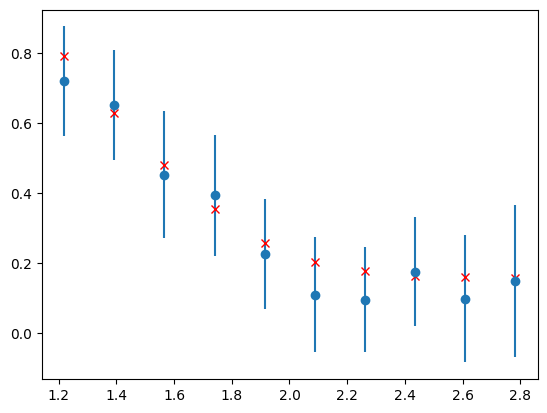

In [122]:
all_std
error_bars = np.array(all_std).T
asymmetric_error = [all_mean_estimates - error_bars[0], error_bars[1] - all_mean_estimates]

import matplotlib.pyplot as plt
plt.errorbar(strike_prices, all_mean_estimates, yerr = asymmetric_error, fmt='o')
# plt.plot(strike_prices, np.array(all_mean_estimates), 'o')
plt.plot(strike_prices, exact_expectations, 'rx')